<a href="https://colab.research.google.com/github/XANDOOM/XANDOOM/blob/main/Autonomous_Driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [33]:
from tensorflow.keras import layers

In [3]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add

from google.colab import drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/College/Cars/'

COLAB_DIR = '/content/'
GT_DIR = COLAB_DIR + 'gtFine/gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/leftImg8bit/'

Mounted at /gdrive


In [82]:
#!pip install cityscapesscripts
from cityscapesscripts.download import downloader
# registration on https://www.cityscapes-dataset.com/
session = downloader.login()

# Getting the data

In [5]:
# data for semantic segmentation task
print('Downloading gtFine and leftImg8bit packages ...\n')
package_list =['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip']
downloader.download_packages(session=session, package_names=package_list, destination_path=COLAB_DIR)

In [6]:
!unzip -q gtFine_trainvaltest.zip -d gtFine
!unzip -q leftImg8bit_trainvaltest.zip -d leftImg

#### Preprocess & Archive

In [7]:
# collapse child directories
for parent in listdir(GT_DIR):
    parent_dir = GT_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png')
            keep = [f.split('/')[-1] for f in keep]
            for filename in list(set(listdir(join(parent_dir, child))) & set(keep)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

for parent in listdir(IMG_DIR):
    parent_dir = IMG_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            for filename in listdir(join(parent_dir, child)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

In [8]:
# process and archive image in smaller size
IMG_SHAPE = 99, 99

gt_train_paths = [GT_DIR+'train/' + path for path in listdir(GT_DIR+'train/')]
gt_test_paths = [GT_DIR+'test/' + path for path in listdir(GT_DIR+'test/')]
gt_val_paths = [GT_DIR+'val/' + path for path in listdir(GT_DIR+'val/')]
gt_paths = gt_train_paths + gt_test_paths + gt_val_paths

im_train_paths = [IMG_DIR+'train/' + path for path in listdir(IMG_DIR+'train/')]
im_test_paths = [IMG_DIR+'test/' + path for path in listdir(IMG_DIR+'test/')]
im_val_paths = [IMG_DIR+'val/' + path for path in listdir(IMG_DIR+'val/')]
im_paths = im_train_paths + im_test_paths + im_val_paths

def resize_image(path):
    img = Image.open(path)
    img.thumbnail(IMG_SHAPE)
    out_file = join(path)
    img.save(out_file, 'PNG')

for img in gt_paths + im_paths:
    resize_image(img)

make_archive('gtFine', 'zip', GT_DIR)
make_archive('leftImg', 'zip', IMG_DIR)

'/content/leftImg.zip'

#### Load Archive Data

In [9]:
def download_if_missing(url, target, extract=True):
    if os.path.exists(target):
        return target
    return tf.keras.utils.get_file(target, origin=url, extract=extract)

gt_url_file = 'https://storage.googleapis.com/mcg2208/gtFine.zip'
im_url_file = 'https://storage.googleapis.com/mcg2208/leftImg.zip'

gt_file, gt_dir = join(COLAB_DIR + 'gtFine.zip'), join(COLAB_DIR + 'gtFine/')
im_file, im_dir = join(COLAB_DIR + 'leftImg.zip'), join(COLAB_DIR + 'leftImg/')

download_if_missing(gt_url_file, gt_file, extract=False)
download_if_missing(im_url_file, im_file, extract=False)

!unzip -q $gt_file -d $gt_dir
!unzip -q $im_file -d $im_dir

In [10]:
# normalize image pixels
IMG_SIZE = 240
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/'

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# create tf.Dataset objects
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'val/'))
gt_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'test/'))

gt_train_ds = gt_train_ds.map(load_and_preprocess_image)
gt_val_ds = gt_val_ds.map(load_and_preprocess_image)
gt_test_ds = gt_test_ds.map(load_and_preprocess_image)

im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))

im_train_ds = im_train_ds.map(load_and_preprocess_image)
im_val_ds = im_val_ds.map(load_and_preprocess_image)
im_test_ds = im_test_ds.map(load_and_preprocess_image)

# Visualise Data

In [11]:
def visualize_images(img, gt, pred):
    if pred is not None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].imshow(img)
    axes[0].set_title('Actual Image')

    axes[1].imshow(gt)
    axes[1].set_title('Masked Image')
    
    if pred is not None:
        axes[2].imshow(pred)
        axes[2].set_title('Predicted Image')

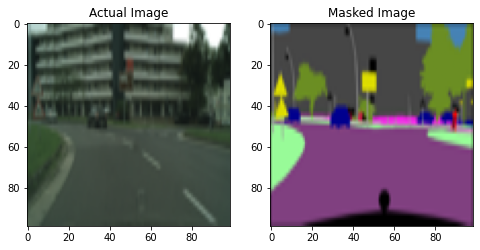

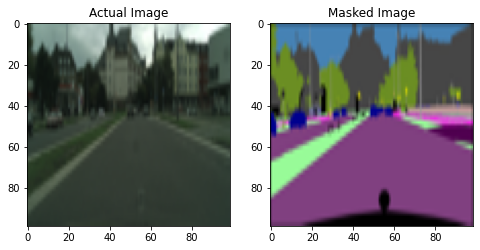

In [12]:
for img, gt in list(zip(im_train_ds.take(2), gt_train_ds.take(2))):
    visualize_images(img, gt, None)

# Model

In [26]:
# normalize image pixels
IMG_SIZE1 =128
IMG_SIZE2 =128
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/'
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE1, IMG_SIZE2])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# data transformation using K-means
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), 
              (0,255,255), (255,255,255), (200,50,0),(50,200,0), (50,0,200), 
              (200,200,50), (0,50,200), (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg
    
def train_kmeans(K=13):
    colors = []
    kmeans_gt_train_paths = [GT_DIR + 'train/' + path for path in listdir(GT_DIR + 'train/')[:20]]
    kmeans_gt_train_ds = tf.data.Dataset.from_tensor_slices(kmeans_gt_train_paths)
    kmeans_gt_train_ds = kmeans_gt_train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    for seg in kmeans_gt_train_ds:
        colors.append(tf.reshape(seg, (seg.shape[0]*seg.shape[1], 3) ))
    colors = tf.concat(colors, 0) 
    print("Training K means on colors data of shape :",colors.shape)
    km = KMeans(K)
    km.fit(colors)
    print("\nK-means clustering trained\n", km)
    return km

# Traing a k-means classifier
km=train_kmeans(13)

def load_and_preprocess_segment(path):
    seg = load_and_preprocess_image(path)
    s = tf.reshape(seg, (seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = tf.reshape(s, (seg.shape[0], seg.shape[1]))
    n = len(km.cluster_centers_)
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        cls[:,:,i]=m

    seg = tf.convert_to_tensor(cls, dtype=tf.float32)
    return seg

Training K means on colors data of shape : (327680, 3)

K-means clustering trained
 KMeans(n_clusters=13)


In [27]:
# train data
im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_train_ds = im_train_ds.map(load_and_preprocess_image)

gt_train_paths = get_image_paths(GT_DIR+'train/')
gt_train_ds = map(load_and_preprocess_segment, gt_train_paths)
gt_train_ds = tf.data.Dataset.from_tensor_slices([a for a in gt_train_ds])
train_ds = tf.data.Dataset.zip((im_train_ds, gt_train_ds))
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print('Training Data:\n# of batches, Input batch shape, Ouput batch shape')
print(len(train_ds), next(iter(train_ds))[0].shape, next(iter(train_ds))[1].shape)

Training Data:
# of batches, Input batch shape, Ouput batch shape
93 (32, 128, 128, 3) (32, 128, 128, 13)


In [28]:
# val data
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_val_ds = im_val_ds.map(load_and_preprocess_image)

gt_val_paths = get_image_paths(GT_DIR+'val/')
gt_val_ds = map(load_and_preprocess_segment, gt_val_paths)
gt_val_ds = tf.data.Dataset.from_tensor_slices([a for a in gt_val_ds])
val_ds = tf.data.Dataset.zip((im_val_ds, gt_val_ds))
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


print('Validation Data:\n# of batches, Input batch shape, Ouput batch shape')
print(len(val_ds), next(iter(val_ds))[0].shape, next(iter(val_ds))[1].shape)

Validation Data:
# of batches, Input batch shape, Ouput batch shape
16 (32, 128, 128, 3) (32, 128, 128, 13)


In [29]:
# test data
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))
im_test_ds = im_test_ds.map(load_and_preprocess_image)

gt_test_paths = get_image_paths(GT_DIR+'test/')
gt_test_ds = map(load_and_preprocess_segment, gt_test_paths)
gt_test_ds = tf.data.Dataset.from_tensor_slices([a for a in gt_test_ds])
test_ds = tf.data.Dataset.zip((im_test_ds, gt_test_ds))
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print('Testing Data:\n# of batches, Input batch shape, Ouput batch shape')
print(len(test_ds), next(iter(test_ds))[0].shape, next(iter(test_ds))[1].shape)

Testing Data:
# of batches, Input batch shape, Ouput batch shape
48 (32, 128, 128, 3) (32, 128, 128, 13)


In [32]:
print(im_test_ds)
print(gt_test_ds)

<MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
<TensorSliceDataset element_spec=TensorSpec(shape=(128, 128, 13), dtype=tf.float32, name=None)>


# Model Definition

In [34]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [47]:
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   f1, p1 = downsample_block(inputs, 32)
   f2, p2 = downsample_block(p1, 64)
   f3, p3 = downsample_block(p2, 128)

   # 5 - bottleneck
   bottleneck = double_conv_block(p3, 256)

   # decoder: expanding path - upsample
   u6 = upsample_block(bottleneck, f3, 128)
   u7 = upsample_block(u6, f2, 64)
   u8 = upsample_block(u7, f1, 32)

   # outputs
   outputs = layers.Conv2D(13, 1, padding="same", activation = "softmax")(u8)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [48]:
model = build_unet_model()

In [49]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_70 (Conv2D)             (None, 128, 128, 32  896         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_70[0][0]']              
                                )                                                             

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [61]:
NUM_EPOCHS = 20

TRAIN_LENGTH = 93
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = 48
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_ds,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=val_ds)

Epoch 1/20
2/2 [==============================] - 28s 13s/step - loss: 2.5822 - accuracy: 0.0633
Epoch 2/20
2/2 [==============================] - 27s 13s/step - loss: 2.4226 - accuracy: 0.2123
Epoch 3/20
2/2 [==============================] - 29s 16s/step - loss: 2.3529 - accuracy: 0.2963
Epoch 4/20
2/2 [==============================] - 26s 13s/step - loss: 2.2587 - accuracy: 0.3211
Epoch 5/20
2/2 [==============================] - 26s 13s/step - loss: 2.1446 - accuracy: 0.3150
Epoch 6/20
2/2 [==============================] - 26s 13s/step - loss: 2.2056 - accuracy: 0.3250
Epoch 7/20
2/2 [==============================] - 26s 13s/step - loss: 2.1564 - accuracy: 0.3350
Epoch 8/20
2/2 [==============================] - 28s 15s/step - loss: 2.1337 - accuracy: 0.3364
Epoch 9/20
2/2 [==============================] - 26s 13s/step - loss: 2.0814 - accuracy: 0.3241
Epoch 10/20
2/2 [==============================] - 26s 13s/step - loss: 2.0272 - accuracy: 0.3255
Epoch 11/20
2/2 [============

##### Model Training & Evaluation

In [54]:
# loading trained model
checkpoint_path_old = drive_root+'cpt_12dec/cp.ckpt'
checkpoint_dir_old = os.path.dirname(checkpoint_path_old)
# load model
model = build_unet_model()
model.load_weights(checkpoint_path_old)
# Re-evaluate loaded model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

NotFoundError: ignored

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [63]:
model2 = model

In [64]:
# retrain model
checkpoint_path = drive_root+'cpt_27july/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model2.fit(train_ds, epochs=2, validation_data=val_ds, verbose=1, callbacks=[cp_callback]) 

model2.save(drive_root+'trained_model_27july.h5')

loss, acc = model2.evaluate(val_ds, verbose=2)
print("Retrained model, accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/2
93/93 [==============================] - ETA: 0s - loss: 1.5786 - accuracy: 0.4776 
Epoch 1: saving model to /gdrive/My Drive/College/Cars/cpt_27july/cp.ckpt
93/93 [==============================] - 1298s 14s/step - loss: 1.5786 - accuracy: 0.4776 - val_loss: 1.3157 - val_accuracy: 0.5833
Epoch 2/2
93/93 [==============================] - ETA: 0s - loss: 1.1778 - accuracy: 0.6044 
Epoch 2: saving model to /gdrive/My Drive/College/Cars/cpt_27july/cp.ckpt
93/93 [==============================] - 1330s 14s/step - loss: 1.1778 - accuracy: 0.6044 - val_loss: 1.1154 - val_accuracy: 0.6351
16/16 - 60s - loss: 1.1154 - accuracy: 0.6351 - 60s/epoch - 4s/step
Retrained model, accuracy: 63.51%


##### Prediction Visualization

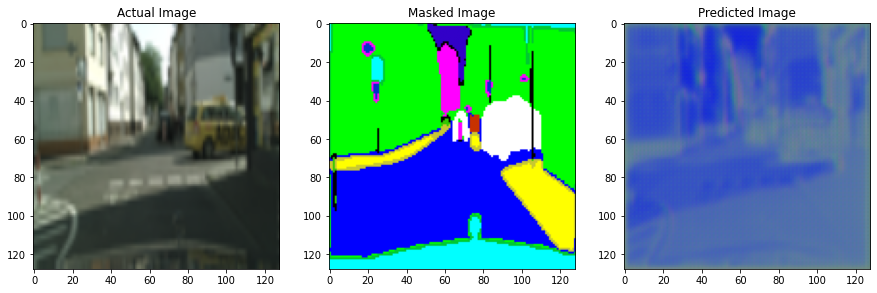

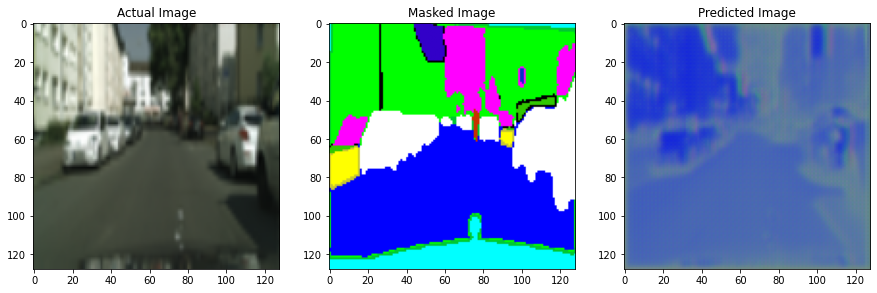

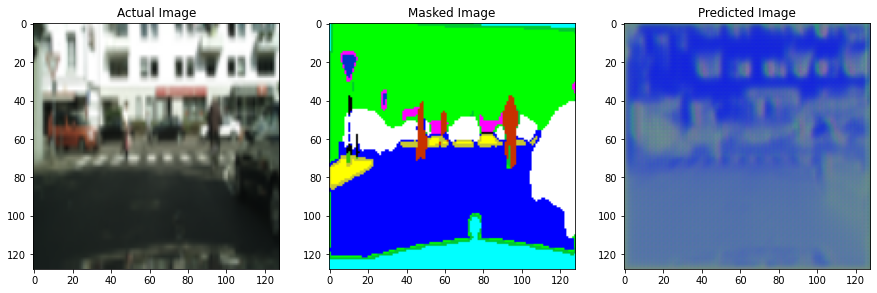

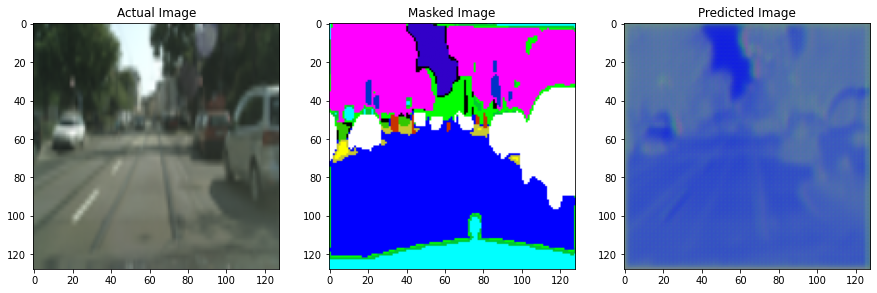

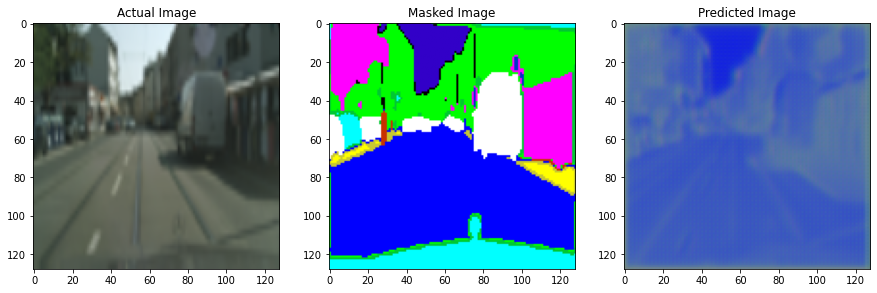

In [62]:
max_show=4
for imgs, segs in val_ds:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        predimg = _p
        trueimg = _s

        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title("Actual Image")
        plt.imshow(imgs[i])

        plt.subplot(132)
        plt.title("Masked Image")
        plt.imshow(_s)
        # plt.axis("off")

        plt.subplot(133)
        plt.title("Predicted Image")
        plt.imshow(_p)
        # plt.tight_layout()

        plt.show()
    break

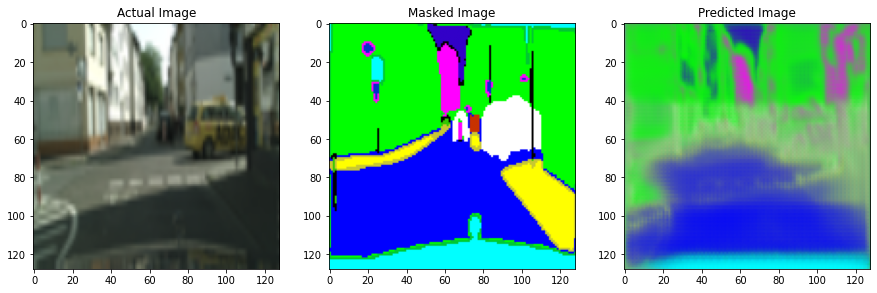

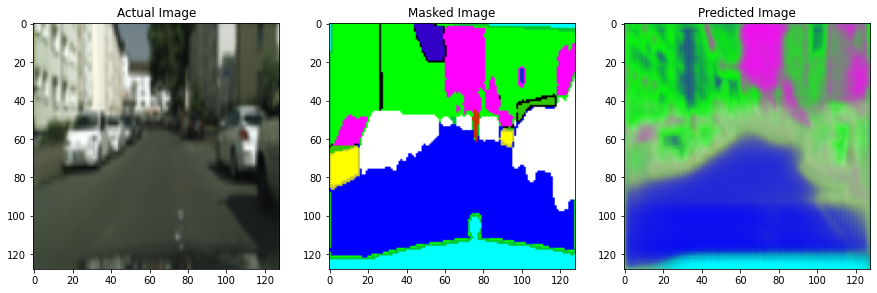

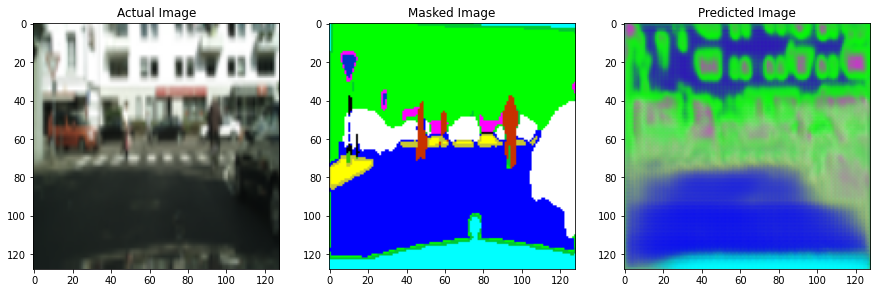

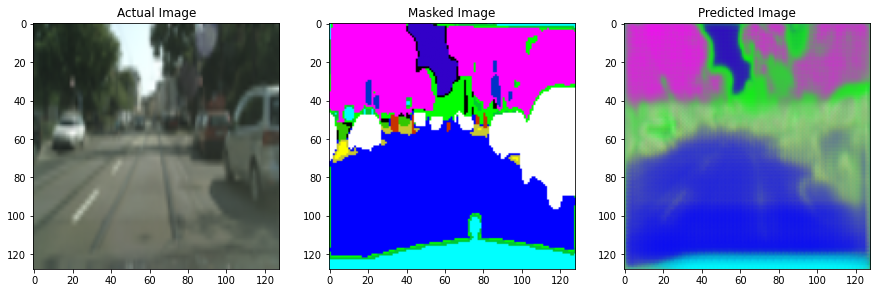

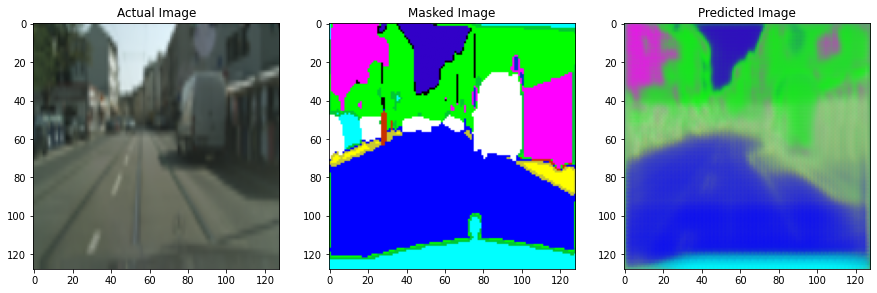

In [65]:
#model 2
max_show=4
for imgs, segs in val_ds:
    p = model2.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        predimg = _p
        trueimg = _s

        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title("Actual Image")
        plt.imshow(imgs[i])

        plt.subplot(132)
        plt.title("Masked Image")
        plt.imshow(_s)
        # plt.axis("off")

        plt.subplot(133)
        plt.title("Predicted Image")
        plt.imshow(_p)
        # plt.tight_layout()

        plt.show()
    break

In [83]:
model3 = model2

In [84]:
# retrain model
checkpoint_path = drive_root+'cpt_27july/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model3.fit(train_ds, epochs=2, validation_data=val_ds, verbose=1, callbacks=[cp_callback]) 

model3.save(drive_root+'trained_model_27july.h5')

loss, acc = model2.evaluate(val_ds, verbose=2)
print("Retrained model, accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/2
93/93 [==============================] - ETA: 0s - loss: 1.1749 - accuracy: 0.6365 
Epoch 1: saving model to /gdrive/My Drive/College/Cars/cpt_27july/cp.ckpt
93/93 [==============================] - 1350s 14s/step - loss: 1.1749 - accuracy: 0.6365 - val_loss: 1.1879 - val_accuracy: 0.6518
Epoch 2/2
93/93 [==============================] - ETA: 0s - loss: 1.4493 - accuracy: 0.6205 
Epoch 2: saving model to /gdrive/My Drive/College/Cars/cpt_27july/cp.ckpt
93/93 [==============================] - 1363s 15s/step - loss: 1.4493 - accuracy: 0.6205 - val_loss: 1.2060 - val_accuracy: 0.6326
16/16 - 53s - loss: 1.2060 - accuracy: 0.6326 - 53s/epoch - 3s/step
Retrained model, accuracy: 63.26%


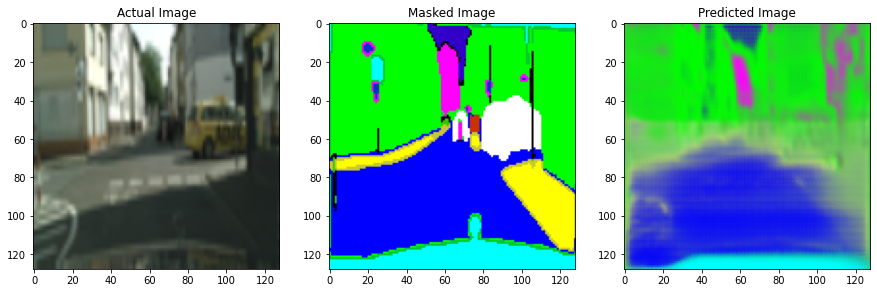

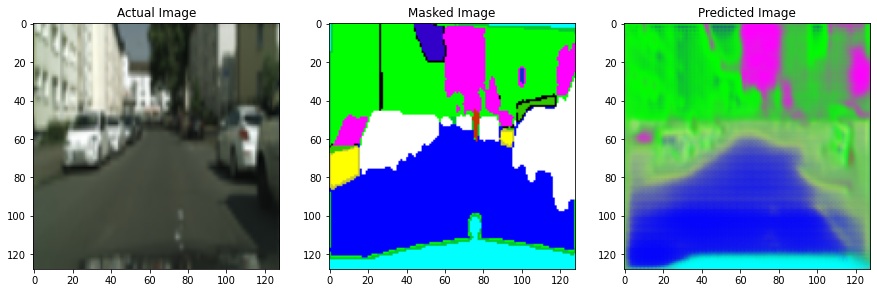

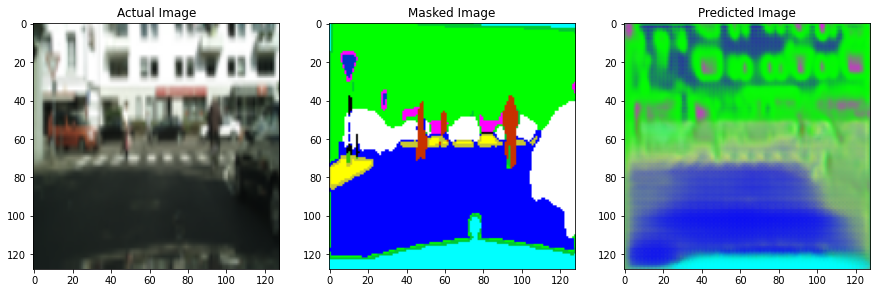

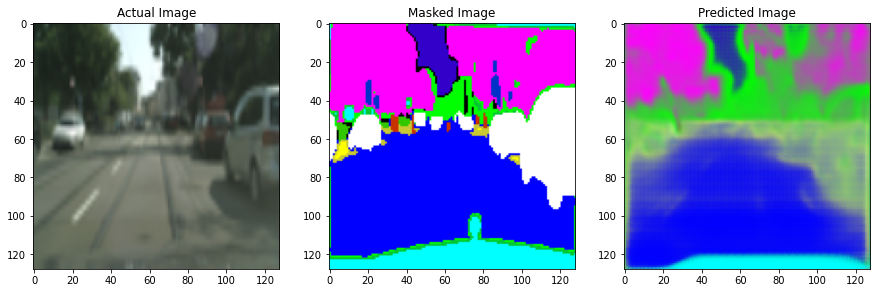

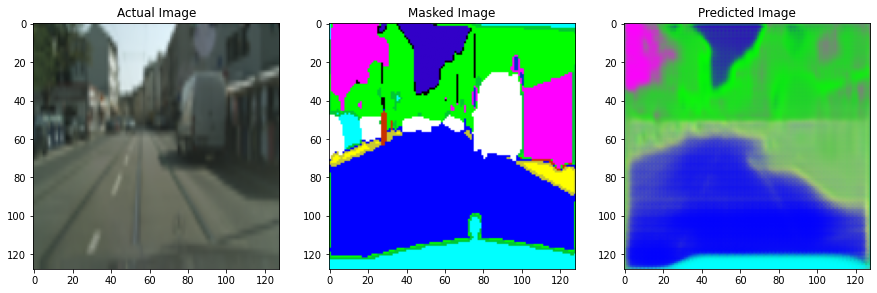

In [86]:
#model 3
max_show=4
for imgs, segs in val_ds:
    p = model3.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        predimg = _p
        trueimg = _s

        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title("Actual Image")
        plt.imshow(imgs[i])

        plt.subplot(132)
        plt.title("Masked Image")
        plt.imshow(_s)
        # plt.axis("off")

        plt.subplot(133)
        plt.title("Predicted Image")
        plt.imshow(_p)
        # plt.tight_layout()

        plt.show()
    break

### **4. Evaluation on Video**

*code to leverage the trained model to provide real-time segmented road scene prediction from video.*

In [ ]:
checkpoint_path = drive_root+'cpt_27july/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

model2.load_weights(checkpoint_path)

In [73]:
from google.colab.patches import cv2_imshow
vidcap = cv2.VideoCapture('carssss.mp4') # upload file
success, image = vidcap.read()
count = 0

# video to frames generation
while success:
    cv2.imwrite('orig_frame_%.3d.jpg' % count, image)  # save frame as JPEG file
    success, image = vidcap.read()
    count += 1

frames = [img for img in get_image_paths(COLAB_DIR) if img.endswith('.jpg')]

def convert_to_video(image_paths, video_name):
    frame = cv2.imread(image_paths[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, 0, 30, (width,height))
    for image in image_paths:
        video.write(cv2.imread(image))
    
    cv2.destroyAllWindows()
    video.release()
  
# model predictions on generated frames
eval_ds2 = tf.data.Dataset.from_tensor_slices(frames)
eval_ds2 = eval_ds2.map(load_and_preprocess_image)
eval_ds2 = eval_ds2.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
convert_to_video(frames, 'original_video.avi')

pred_frames = model2.predict(eval_ds2)
count = 0
for image in pred_frames:
    image = LayersToRGBImage(image)
    plt.imsave('pred_frame_%.3d.png' % count, image)
    count += 1
# converting predictions to a video back
frames = [img for img in get_image_paths(COLAB_DIR) if img.endswith('.png')]
convert_to_video(frames, 'predicted_video.avi')

In [72]:
pred_frames = model2.predict(eval_ds2)
count = 0
for image in pred_frames:
    image = LayersToRGBImage(image)
    plt.imsave('pred_frame_%.3d.png' % count, image)
    count += 1
# converting predictions to a video back
frames = [img for img in get_image_paths(COLAB_DIR) if img.endswith('.png')]
convert_to_video(frames, 'predicted_video.avi')

In [ ]:
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture("carssss.mp4")
ret, frame = cap.read()
while(1):
   ret, frame = cap.read()
   cv2_imshow(frame)
   if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
       cap.release()
       cv2.destroyAllWindows()
       break
   cv2_imshow(frame)

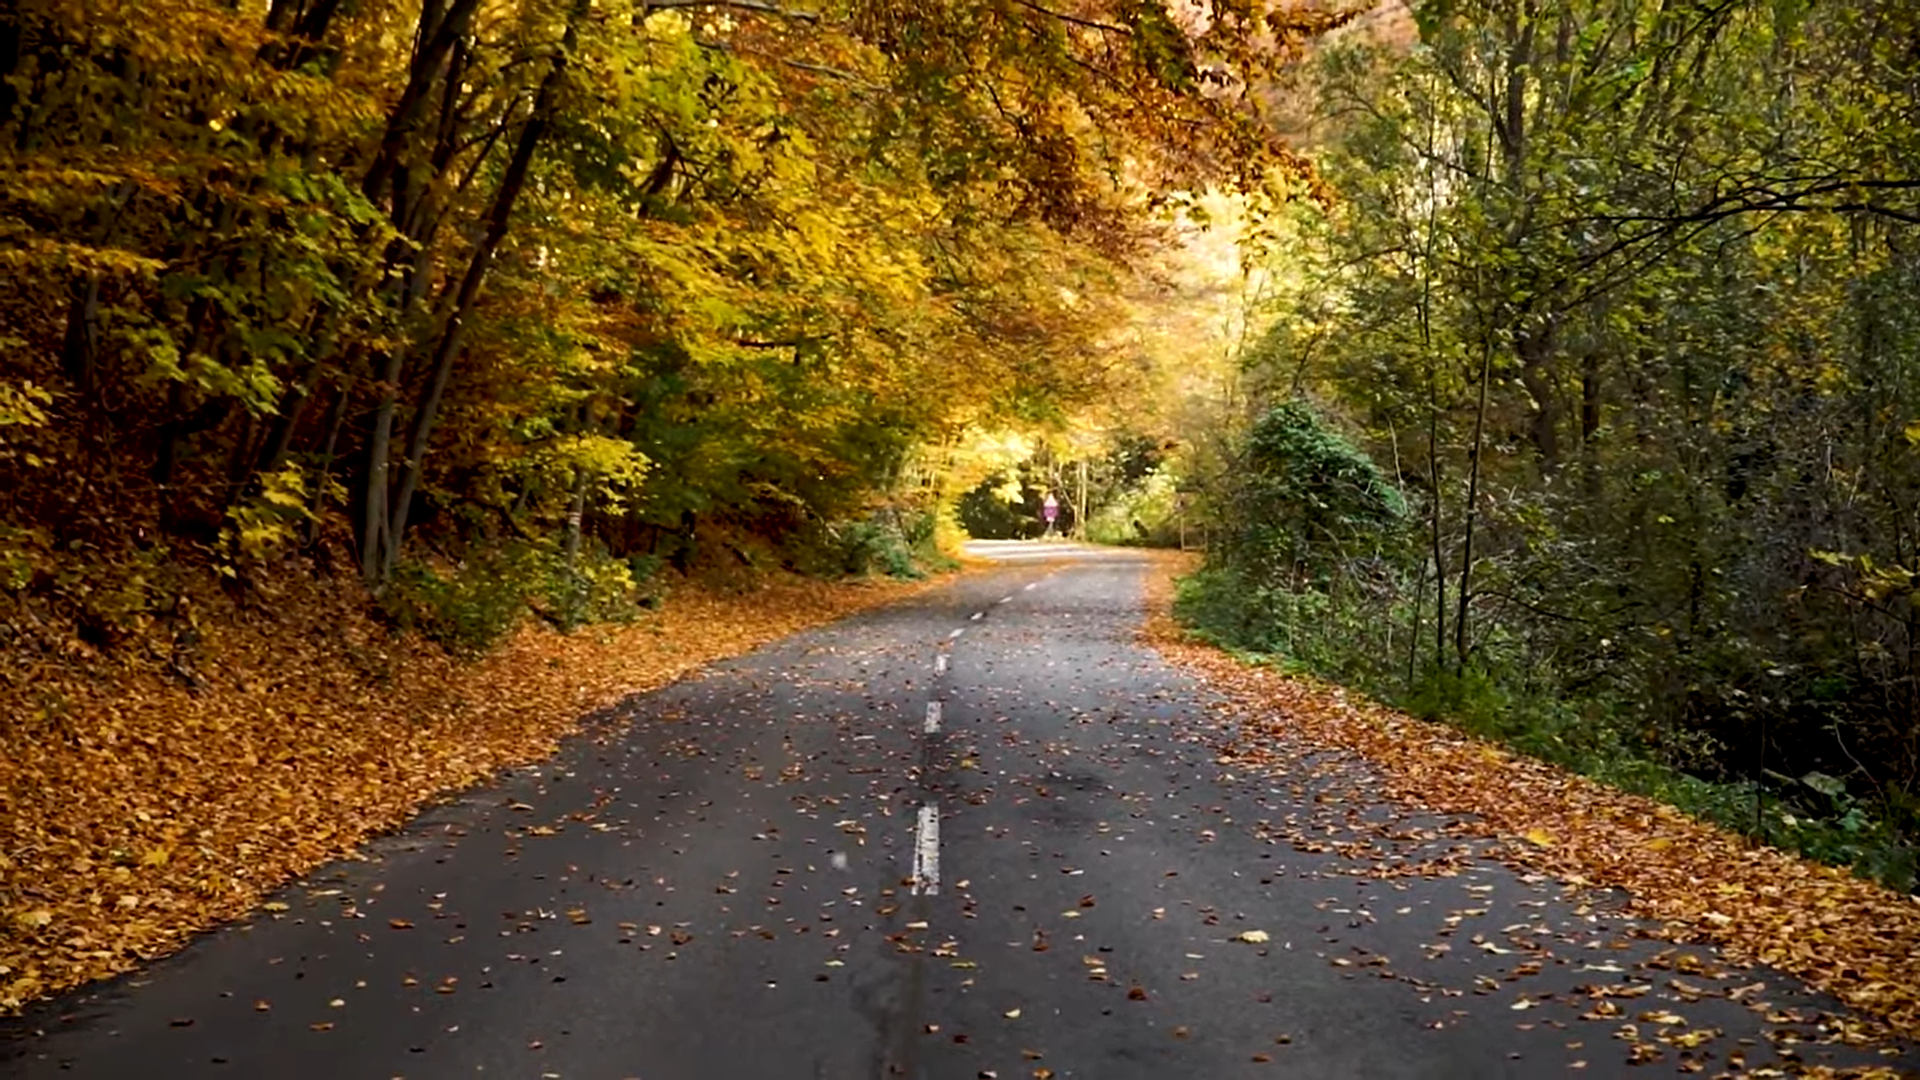

In [101]:
from PIL import Image
image = Image.open("/content/road_tree.png")
display(image)